In [772]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ptitprince as pt
import inspect
from scipy.stats import t

In [773]:
shared_control_ssrt = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_ssrt.csv")
simple_stop_ssrt = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/simple_stop_metrics.csv")
participant_tracking = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/participant_tracking.csv')
survey_results = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/survey_scores.csv')
go_task_accuracy_before_stop_onset = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_go_task_accuracy_before_stop_onset.csv')
go_task_accuracy_after_stop_onset = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_go_task_accuracy_after_stop_onset.csv')
duration_of_inhibition = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_duration_of_inhibition.csv")
proportion_of_trials_with_stop_moment = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/proportion_of_trials_with_stop_moment.csv")
ssrt_first_half = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_ssrt_first_half.csv")
ssrt_second_half = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_ssrt_second_half.csv")

In [774]:
# Set the first column as the index to use for merging (assuming it's the subject ID)
shared_control_ssrt.columns = ['subject_id'] + list(shared_control_ssrt.columns[1:])
simple_stop_ssrt.columns = ['subject_id'] + list(simple_stop_ssrt.columns[1:])

# Merge by the first (subject_id) column
merged_df = pd.merge(shared_control_ssrt, simple_stop_ssrt[['subject_id', 'ssrt']], on='subject_id', how='left')

# Rename columns
merged_df.rename(columns={'ssrt': 'simple_stop_ssrt', 'ai_ssrt': 'ai_disengaged_ssrt', 'ai_ai_ssrt': 'ai_engaged_ssrt'}, inplace=True)

In [775]:
# Remove the last row, assuming it's the mean row
merged_df = merged_df.iloc[:-1, :]
go_task_accuracy_before_stop_onset = go_task_accuracy_before_stop_onset.iloc[:-1, :]
go_task_accuracy_after_stop_onset = go_task_accuracy_after_stop_onset.iloc[:-1, :]
duration_of_inhibition = duration_of_inhibition.iloc[:-1, :]
proportion_of_trials_with_stop_moment = proportion_of_trials_with_stop_moment.iloc[:-1, :]
ssrt_first_half = ssrt_first_half.iloc[:-1, :]
ssrt_second_half = ssrt_second_half.iloc[:-1, :]

## Stats Functions

In [776]:
def cohens_d_paired(x1, x2):
    """Calculate Cohen's d for paired samples"""
    d = (x1 - x2).mean() / np.sqrt(((x1 - x2).std(ddof=1) ** 2) / 2)
    return d

# Calculate mean difference and confidence intervals for SSRT differences
def calculate_ci_for_difference(x1, x2, confidence=0.95):
    """Calculate confidence interval for the mean difference between two paired samples"""
    diff = x1 - x2
    n = len(diff)
    mean_diff = np.mean(diff)
    sem = stats.sem(diff)  # Standard error of the mean
    ci = stats.t.interval(confidence, n-1, loc=mean_diff, scale=sem)
    return mean_diff, ci

In [777]:
def calc_stats_ind(x1, x2):
    """Calculate Cohen's d, DF, 95% CI for two independent samples"""
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(x1, x2, nan_policy='omit')
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

    # Calculate Cohen's d
    mean_x1 = np.mean(x1)
    mean_x2 = np.mean(x2)
    std_x1 = np.std(x1, ddof=1)  # Sample standard deviation
    std_x2 = np.std(x2, ddof=1)

    # Pooled standard deviation
    n1 = len(x1)
    n2 = len(x2)
    pooled_std = np.sqrt(((n1 - 1) * std_x1**2 + (n2 - 1) * std_x2**2) / (n1 + n2 - 2))

    # Cohen's d
    cohens_d = (mean_x1 - mean_x2) / pooled_std
    print(f"Cohen's d: {cohens_d:.3f}")

    # Degrees of freedom
    degrees_of_freedom = n1 + n2 - 2
    print(f"Degrees of Freedom: {degrees_of_freedom}")

    # Confidence Interval Calculation
    mean_diff = mean_x1 - mean_x2
    se_diff = np.sqrt((std_x1**2 / n1) + (std_x2**2 / n2))

    # 95% CI
    ci = stats.t.interval(0.95, df=degrees_of_freedom, loc=mean_diff, scale=se_diff)
    print(f"95% CI for mean difference: [{ci[0]:.3f}, {ci[1]:.3f}]")

In [778]:
def calc_ci_for_individual_metrics(df):
    """ Calculate means and confidence intervals for individual metrics such as Non-AI SSRT"""
    third_column_name = df.columns[2]  # Get the name of the third column (index 2)

    # Group by 'Condition' and compute Mean and SEM for the third column
    means_df = df.groupby('Condition').agg(
        Mean=(third_column_name, 'mean'),
        SEM=(third_column_name, stats.sem)  # Standard error of the mean for this column
    ).reset_index()

    # Ensure correct ordering in means_df
    means_df['Condition'] = pd.Categorical(means_df['Condition'], ordered=True)
    means_df = means_df.sort_values('Condition')

    # Calculate the degrees of freedom
    n = df.shape[0]  # Total number of samples
    df = n - 1  # Degrees of freedom

    # Calculate the confidence intervals
    confidence_level = 0.95
    ci_bounds = stats.t.interval(confidence_level, df, loc=means_df['Mean'], scale=means_df['SEM'])
    means_df['CI_lower'] = ci_bounds[0]
    means_df['CI_upper'] = ci_bounds[1]

    # Print means_df to check the order
    print("Means DataFrame:")
    print(means_df)

## Planned Statistical Tests

In [779]:
# Reshape the data for repeated measures ANOVA
data_long = pd.melt(merged_df, id_vars=['subject_id'], value_vars=['non_ai_ssrt', 'ai_disengaged_ssrt', 'simple_stop_ssrt'],
                    var_name='condition', value_name='SSRT')


# Run the repeated measures ANOVA
aovrm = AnovaRM(data_long, 'SSRT', 'subject_id', within=['condition'])
anova_results = aovrm.fit()

In [780]:
# Conduct the paired t-tests for planned comparisons

# Comparison 1: AI Stop vs non-AI Stop
ai_vs_non_ai = stats.ttest_rel(merged_df['ai_disengaged_ssrt'], merged_df['non_ai_ssrt'])
print(f"AI Disengaged vs Non-AI SSRT Comparison: t-statistic = {ai_vs_non_ai.statistic}, p-value = {ai_vs_non_ai.pvalue}")

# Comparison 2: Non-AI vs Simple Stopping
non_ai_vs_simple = stats.ttest_rel(merged_df['non_ai_ssrt'], merged_df['simple_stop_ssrt'])
non_ai_vs_simple_corr = np.corrcoef(merged_df['non_ai_ssrt'], merged_df['simple_stop_ssrt'])[1][0]
print(f"Non-AI vs Simple Stopping SSRT Comparison: t-statistic = {non_ai_vs_simple.statistic}, p-value = {non_ai_vs_simple.pvalue}")
print(non_ai_vs_simple_corr)

AI Disengaged vs Non-AI SSRT Comparison: t-statistic = 5.829069557315186, p-value = 8.947284304246281e-07
Non-AI vs Simple Stopping SSRT Comparison: t-statistic = 13.335317900235957, p-value = 4.1284915082684623e-16
0.5303411888448846


In [781]:
# Find cohen's d, mean difference, and 95% CI
# Comparison 1: AI Stop vs non-AI Stop
cohens_d1 = cohens_d_paired(merged_df['ai_disengaged_ssrt']*1000, merged_df['non_ai_ssrt']*1000)
mean_diff1, ci1 = calculate_ci_for_difference(merged_df['ai_disengaged_ssrt']*1000, merged_df['non_ai_ssrt']*1000)
print("\nAI Disengaged vs Non-AI SSRT:")
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")

# Comparison 2: Non-AI vs Simple Stopping
cohens_d2 = cohens_d_paired(merged_df['non_ai_ssrt']*1000, merged_df['simple_stop_ssrt']*1000)
mean_diff2, ci2 = calculate_ci_for_difference(merged_df['non_ai_ssrt']*1000, merged_df['simple_stop_ssrt']*1000)
print("\nNon-AI vs Simple Stopping SSRT:")
print(f"Cohen's d: {cohens_d2:.3f}")
print(f"Mean difference = {mean_diff2:.3f} ms")
print(f"95% CI: [{ci2[0]:.3f}, {ci2[1]:.3f}] ms")


AI Disengaged vs Non-AI SSRT:
Cohen's d: 1.303
Mean difference = 22.715 ms
95% CI: [14.833, 30.597] ms

Non-AI vs Simple Stopping SSRT:
Cohen's d: 2.982
Mean difference = 60.615 ms
95% CI: [51.421, 69.809] ms


## Create Tables for the Paper

In [782]:
# Calculate means and standard deviations before and after stop onset
mean_values = go_task_accuracy_before_stop_onset[['non_ai_go_task_accuracy_before_stop_onset', 
                                                   'ai_go_task_accuracy_before_stop_onset', 
                                                   'ai_ai_go_task_accuracy_before_stop_onset']].mean()
sd_values = go_task_accuracy_before_stop_onset[['non_ai_go_task_accuracy_before_stop_onset', 
                                                'ai_go_task_accuracy_before_stop_onset', 
                                                'ai_ai_go_task_accuracy_before_stop_onset']].std()
mean_values_after = go_task_accuracy_after_stop_onset[['non_ai_go_task_accuracy_after_stop_onset', 
                                                       'ai_go_task_accuracy_after_stop_onset', 
                                                       'ai_ai_go_task_accuracy_after_stop_onset']].mean()
sd_values_after = go_task_accuracy_after_stop_onset[['non_ai_go_task_accuracy_after_stop_onset', 
                                                      'ai_go_task_accuracy_after_stop_onset', 
                                                      'ai_ai_go_task_accuracy_after_stop_onset']].std()

# Combine into a single DataFrame with formatted means and SDs in brackets
metrics_mean_sd = pd.DataFrame({
    'Non-AI': [
        f"{round(mean_values['non_ai_go_task_accuracy_before_stop_onset'], 2)} ({round(sd_values['non_ai_go_task_accuracy_before_stop_onset'], 2)})",
        f"{round(mean_values_after['non_ai_go_task_accuracy_after_stop_onset'], 2)} ({round(sd_values_after['non_ai_go_task_accuracy_after_stop_onset'], 2)})",
        f"{round(merged_df['non_ai_ssrt'].mean() * 1000, 2)} ms ({round(merged_df['non_ai_ssrt'].std() * 1000, 2)} ms)"
    ],
    'AI-disengaged': [
        f"{round(mean_values['ai_go_task_accuracy_before_stop_onset'], 2)} ({round(sd_values['ai_go_task_accuracy_before_stop_onset'], 2)})",
        f"{round(mean_values_after['ai_go_task_accuracy_after_stop_onset'], 2)} ({round(sd_values_after['ai_go_task_accuracy_after_stop_onset'], 2)})",
        f"{round(merged_df['ai_disengaged_ssrt'].mean() * 1000, 2)} ms ({round(merged_df['ai_disengaged_ssrt'].std() * 1000, 2)} ms)"
    ],
    'AI-engaged': [
        f"{round(mean_values['ai_ai_go_task_accuracy_before_stop_onset'], 2)} ({round(sd_values['ai_ai_go_task_accuracy_before_stop_onset'], 2)})",
        f"{round(mean_values_after['ai_ai_go_task_accuracy_after_stop_onset'], 2)} ({round(sd_values_after['ai_ai_go_task_accuracy_after_stop_onset'], 2)})",
        f"{round(merged_df['ai_engaged_ssrt'].mean() * 1000, 2)} ms ({round(merged_df['ai_engaged_ssrt'].std() * 1000, 2)} ms)"
    ]
}, index=[
    'Mean of Go Task Accuracy Before Stop Onset',
    'Mean of Stop Success Rate',
    'Mean of SSRT (ms)'
])

# Print the DataFrame
print(metrics_mean_sd)

# Save to CSV
metrics_mean_sd.to_csv('output/shared_control_metrics_mean_sd.csv')

                                                          Non-AI  \
Mean of Go Task Accuracy Before Stop Onset           0.87 (0.08)   
Mean of Stop Success Rate                            0.59 (0.16)   
Mean of SSRT (ms)                           276.17 ms (27.88 ms)   

                                                   AI-disengaged  \
Mean of Go Task Accuracy Before Stop Onset            0.9 (0.08)   
Mean of Stop Success Rate                             0.4 (0.17)   
Mean of SSRT (ms)                           298.88 ms (34.77 ms)   

                                                      AI-engaged  
Mean of Go Task Accuracy Before Stop Onset            0.9 (0.05)  
Mean of Stop Success Rate                            0.92 (0.04)  
Mean of SSRT (ms)                           331.03 ms (61.91 ms)  


## Order Effects

In [783]:
# Calculate order effects between AI being first or Non-AI being first
non_ai_first_subs = participant_tracking[participant_tracking["Cond Order"] == 1]["Subject"].to_list()
ai_first_subs = participant_tracking[participant_tracking["Cond Order"] == 2]["Subject"].to_list()

ssrt_non_ai_first_non_ai = []
ssrt_ai_first_non_ai = []
ssrt_non_ai_first_ai = []
ssrt_ai_first_ai = []
ssrt_non_ai_first_ai_ai = []
ssrt_ai_first_ai_ai = []

for sub in non_ai_first_subs:
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["non_ai_ssrt"].values
    ssrt_non_ai_first_non_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ssrt"].values
    ssrt_non_ai_first_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ai_ssrt"].values
    ssrt_non_ai_first_ai_ai.append(ssrt[0])

for sub in ai_first_subs:
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["non_ai_ssrt"].values
    ssrt_ai_first_non_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ssrt"].values
    ssrt_ai_first_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ai_ssrt"].values
    ssrt_ai_first_ai_ai.append(ssrt[0])

t_stat, p_value = stats.ttest_ind(ssrt_ai_first_non_ai, ssrt_non_ai_first_non_ai, equal_var=False)
print(f'Comparison of Non-AI SSRT between AI-first and Non-AI-first groups: t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}')

t_stat, p_value = stats.ttest_ind(ssrt_ai_first_ai, ssrt_non_ai_first_ai, equal_var=False)
print(f'Comparison of AI SSRT between AI-first and Non-AI-first groups: t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}')

t_stat, p_value = stats.ttest_ind(ssrt_ai_first_ai_ai, ssrt_non_ai_first_ai_ai, equal_var=False)
print(f'Comparison of AI AI SSRT between AI-first and Non-AI-first groups: t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}')
# Calculate the differences between AI SSRT and Non-AI SSRT for both subject groups
diff_non_ai_first = np.array(ssrt_non_ai_first_ai) - np.array(ssrt_non_ai_first_non_ai)  # AI - Non-AI for Non-AI first subjects
diff_ai_first = np.array(ssrt_ai_first_ai) - np.array(ssrt_ai_first_non_ai)  # AI - Non-AI for AI first subjects
print()
print(f'AI - Non-AI difference between groups:')

calc_stats_ind(diff_ai_first, diff_non_ai_first)

#Calculate means and confidence intervals
mean_ai_first = diff_ai_first.mean()
mean_non_ai_first = diff_non_ai_first.mean()

ci_ai_first = stats.t.interval(.95, len(diff_ai_first)-1, loc=mean_ai_first, scale=stats.sem(diff_ai_first))
print(f"Mean difference (AI first): {mean_ai_first:.2f} ms, 95% CI: [{ci_ai_first[0]:.2f}, {ci_ai_first[1]:.2f}] ms")

ci_non_ai_first = stats.t.interval(.95, len(diff_non_ai_first)-1, loc=mean_non_ai_first, scale=stats.sem(diff_non_ai_first))
print(f"Mean difference (Non-AI first): {mean_non_ai_first:.2f} ms, 95% CI: [{ci_non_ai_first[0]:.2f}, {ci_non_ai_first[1]:.2f}] ms")


Comparison of Non-AI SSRT between AI-first and Non-AI-first groups: t-statistic = 0.648, p-value = 0.5211
Comparison of AI SSRT between AI-first and Non-AI-first groups: t-statistic = 1.266, p-value = 0.2134
Comparison of AI AI SSRT between AI-first and Non-AI-first groups: t-statistic = -0.138, p-value = 0.8910

AI - Non-AI difference between groups:
T-statistic: 1.04, P-value: 0.3071
Cohen's d: 0.327
Degrees of Freedom: 38
95% CI for mean difference: [-0.008, 0.024]
Mean difference (AI first): 0.03 ms, 95% CI: [0.01, 0.04] ms
Mean difference (Non-AI first): 0.02 ms, 95% CI: [0.01, 0.03] ms


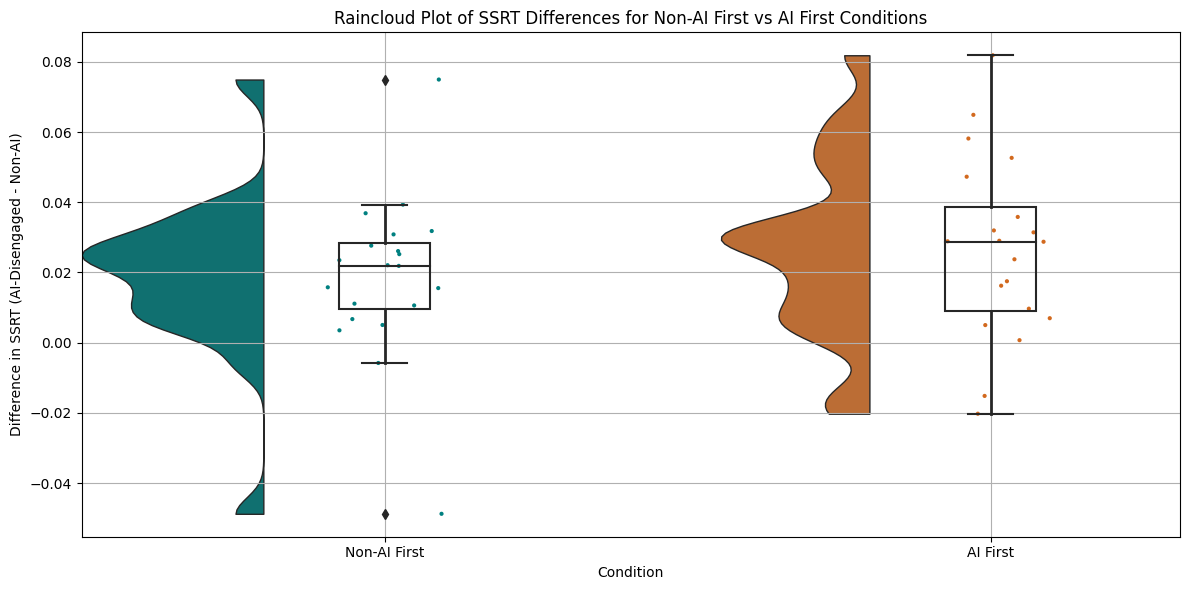

In [784]:
# Create a raincloud plot of Difference in AI - Non AI SSRT for subjects who had the AI block first vs Non AI block first
data_to_plot = {
    'Condition': ['Non-AI First'] * len(diff_non_ai_first) + ['AI First'] * len(diff_ai_first),
    'Difference': np.concatenate((diff_non_ai_first, diff_ai_first))
}

# Create the DataFrame
plot_df = pd.DataFrame(data_to_plot)

# Set up the figure for the raincloud plots
plt.figure(figsize=(12, 6))

# Create the raincloud plot
ax = plt.gca()  # Get the current axes
raincloud = pt.RainCloud(
    x='Condition', 
    y='Difference', 
    data=plot_df,
    palette={"Non-AI First": "teal", 
             "AI First": "chocolate"},
    width_viol=0.6, 
    ax=ax
)

# Add titles and labels
ax.set_title('Raincloud Plot of SSRT Differences for Non-AI First vs AI First Conditions')
ax.set_xlabel('Condition')
ax.set_ylabel('Difference in SSRT (AI-Disengaged - Non-AI)')
ax.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/order_effects_raincloud_plot.png', dpi=300)
plt.show()

In [785]:
# T test for AI vs Non AI SSRT in the first half of trials
ai_vs_non_ai = stats.ttest_rel(ssrt_first_half['ai_ssrt_first_half'], ssrt_first_half['non_ai_ssrt_first_half'])
print(f"AI Disengaged vs Non-AI SSRT Comparison in the first half of trials: t-statistic = {ai_vs_non_ai.statistic:.3f}, p-value = {ai_vs_non_ai.pvalue:.4f}")

cohens_d1 = cohens_d_paired(ssrt_first_half['ai_ssrt_first_half']*1000, ssrt_first_half['non_ai_ssrt_first_half']*1000)
mean_diff1, ci1 = calculate_ci_for_difference(ssrt_first_half['ai_ssrt_first_half']*1000, ssrt_first_half['non_ai_ssrt_first_half']*1000)
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")

ssrt_first_half.columns = ['subject_id'] + list(ssrt_first_half.columns[1:])

melted_df_first_half_ssrt = ssrt_first_half.melt(id_vars='subject_id', value_vars=['non_ai_ssrt_first_half', 'ai_ssrt_first_half'],
                            var_name='Condition', value_name='SSRT')
melted_df_first_half_ssrt['SSRT']*=1000

calc_ci_for_individual_metrics(melted_df_first_half_ssrt)

AI Disengaged vs Non-AI SSRT Comparison in the first half of trials: t-statistic = 3.283, p-value = 0.0022
Cohen's d: 0.734
Mean difference = 21.405 ms
95% CI: [8.217, 34.594] ms
Means DataFrame:
                Condition        Mean       SEM    CI_lower    CI_upper
0      ai_ssrt_first_half  295.269382  7.423677  280.492922  310.045843
1  non_ai_ssrt_first_half  273.863893  4.369819  265.165985  282.561801


In [786]:
# T test for AI vs Non AI SSRT in the second half of all trials
ai_vs_non_ai = stats.ttest_rel(ssrt_second_half['ai_ssrt_second_half'], ssrt_second_half['non_ai_ssrt_second_half'])
print(f"AI Disengaged vs Non-AI SSRT Comparison in the second half of trials: t-statistic = {ai_vs_non_ai.statistic:.3f}, p-value = {ai_vs_non_ai.pvalue:.4f}")

cohens_d1 = cohens_d_paired(ssrt_second_half['ai_ssrt_second_half']*1000, ssrt_second_half['non_ai_ssrt_second_half']*1000)
mean_diff1, ci1 = calculate_ci_for_difference(ssrt_second_half['ai_ssrt_second_half']*1000, ssrt_second_half['non_ai_ssrt_second_half']*1000)
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")

ssrt_second_half.columns = ['subject_id'] + list(ssrt_second_half.columns[1:])

melted_df_second_half_ssrt = ssrt_second_half.melt(id_vars='subject_id', value_vars=['non_ai_ssrt_second_half', 'ai_ssrt_second_half'],
                            var_name='Condition', value_name='SSRT')
melted_df_second_half_ssrt['SSRT']*=1000

calc_ci_for_individual_metrics(melted_df_second_half_ssrt)

AI Disengaged vs Non-AI SSRT Comparison in the second half of trials: t-statistic = 4.820, p-value = 0.0000
Cohen's d: 1.078
Mean difference = 25.485 ms
95% CI: [14.791, 36.180] ms
Means DataFrame:
                 Condition        Mean       SEM    CI_lower    CI_upper
0      ai_ssrt_second_half  303.959558  6.096214  291.825347  316.093769
1  non_ai_ssrt_second_half  278.474436  5.025271  268.471885  288.476987


## Create main plots for the paper

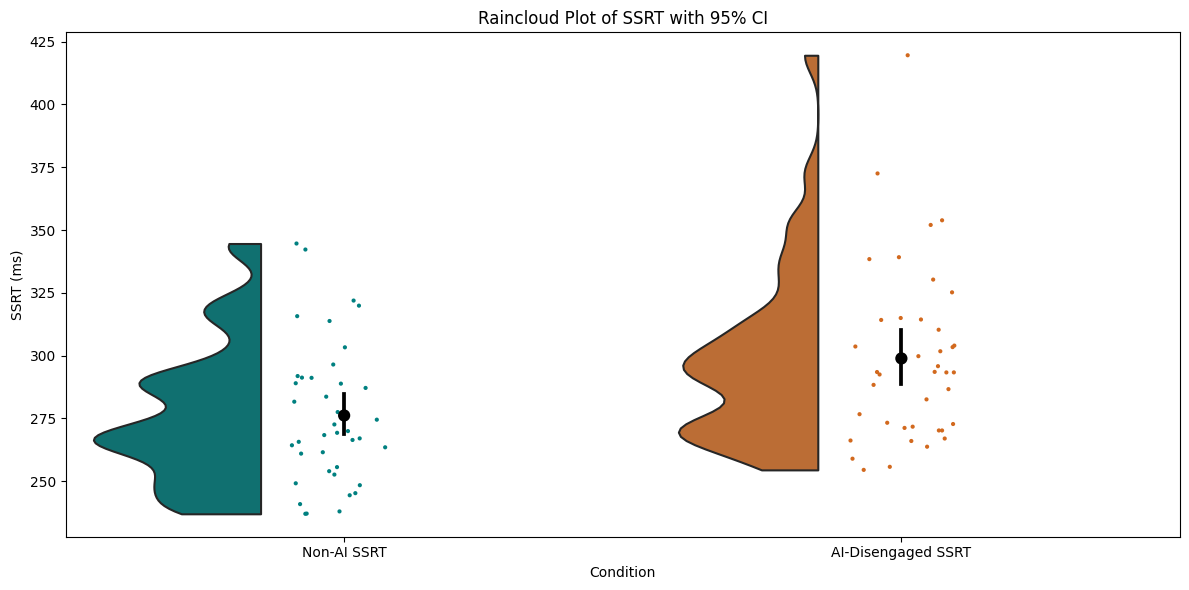

In [787]:
# Combine the data into a long format suitable for Seaborn
melted_df_ssrt = merged_df.melt(id_vars='subject_id', value_vars=['non_ai_ssrt', 'ai_disengaged_ssrt'],
                            var_name='Condition', value_name='SSRT')
melted_df_ssrt['SSRT'] *= 1000  # Convert to milliseconds

custom_names = {
    'non_ai_ssrt': 'Non-AI SSRT',
    'ai_disengaged_ssrt': 'AI-Disengaged SSRT'
}

# Use the mapping to replace the original condition names with custom names
melted_df_ssrt['Condition'] = melted_df_ssrt['Condition'].map(custom_names)

plt.figure(figsize=(12, 6))

# Half-violin plot
ax = pt.half_violinplot(x='Condition', y='SSRT', data=melted_df_ssrt,
                         palette={"Non-AI SSRT": "teal", "AI-Disengaged SSRT": "chocolate"},
                         bw=.2, cut=0., scale="area", width=.6, inner=None)

# Strip plot
ax = sns.stripplot(x='Condition', y='SSRT', data=melted_df_ssrt, palette={"Non-AI SSRT": "teal", "AI-Disengaged SSRT": "chocolate"},
                   color='white', size=3, jitter=1, zorder=0)
#Point plot with confidence intervals
sns.pointplot(data=melted_df_ssrt, x='Condition', y='SSRT',
               ci = 95,
               markers='o', 
               palette={"Non-AI SSRT": "black", "AI-Disengaged SSRT": "black"},
               ax=ax)

# Set the title and labels
ax.set_title('Raincloud Plot of SSRT with 95% CI')
ax.set_ylabel('SSRT (ms)')
ax.set_xlabel('Condition')

# Finalize layout and show the plot
plt.tight_layout()
plt.savefig('figures/non_ai_and_ai_disengaged_ssrt_with_ci.png', dpi=300) 
plt.show()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/lib/python3.12/site

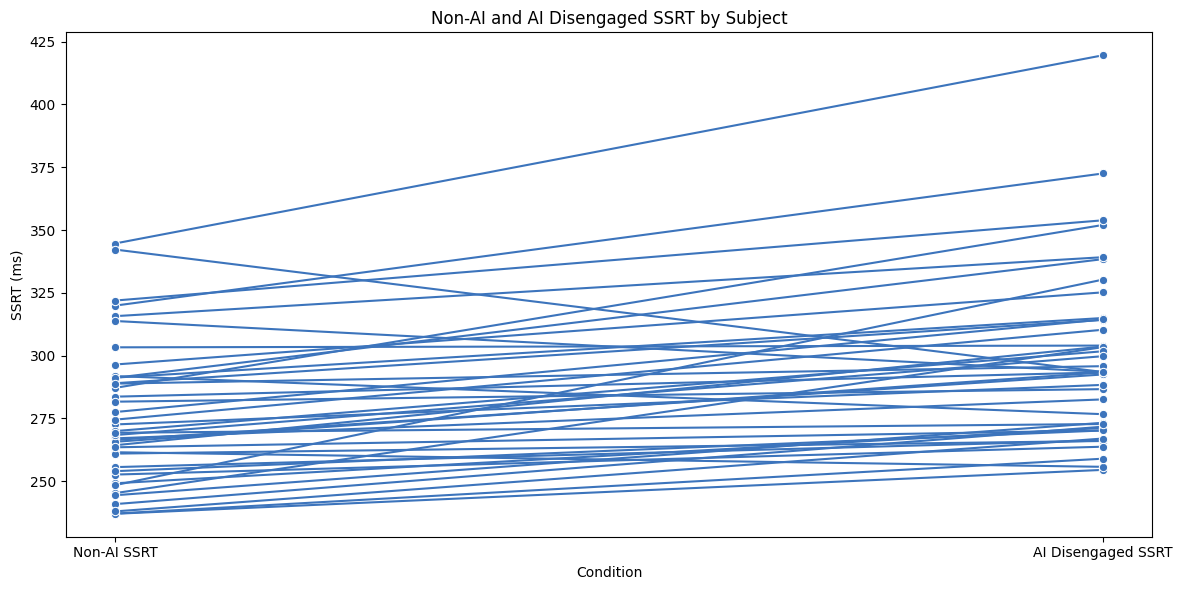

In [788]:
# Create the line plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='Condition', y='SSRT', data=melted_df_ssrt, hue='subject_id', 
                  marker='o', palette=['#3C74BC'] * len(melted_df_ssrt['subject_id'].unique()), legend=False)

# Manually change the condition names in the x-axis labels
ax.set_xticklabels(['Non-AI SSRT', 'AI Disengaged SSRT'])

# Set the title and labels
ax.set_title('Non-AI and AI Disengaged SSRT by Subject')
ax.set_ylabel('SSRT (ms)')

# Finalize layout and save the plot
plt.tight_layout()
plt.savefig('figures/non_ai_and_ai_disengaged_ssrt_by_subject.png', dpi=300)
plt.show()

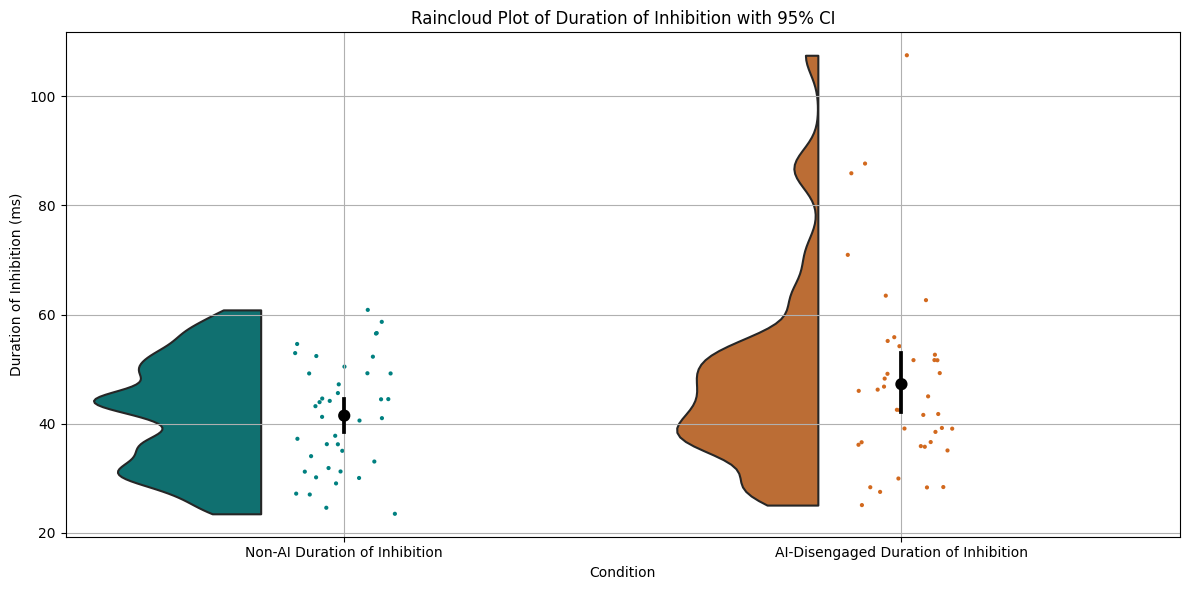

In [789]:
duration_of_inhibition.columns = ['subject_id'] + list(duration_of_inhibition.columns[1:])

melted_df_duration = duration_of_inhibition.melt(id_vars='subject_id', value_vars=['non_ai_duration_of_inhibition', 'ai_duration_of_inhibition'],
                            var_name='Condition', value_name='Duration of Inhibition')

melted_df_duration['Duration of Inhibition'] *= 1000  # Convert to milliseconds

custom_names = {
    'non_ai_duration_of_inhibition': 'Non-AI Duration of Inhibition',
    'ai_duration_of_inhibition': 'AI-Disengaged Duration of Inhibition'
}

melted_df_duration['Condition'] = melted_df_duration['Condition'].map(custom_names)

plt.figure(figsize=(12, 6))
# Half-violin plot
ax = pt.half_violinplot(x='Condition', y='Duration of Inhibition', data=melted_df_duration,
                         palette={"Non-AI Duration of Inhibition": "teal", "AI-Disengaged Duration of Inhibition": "chocolate"},
                         bw=.2, cut=0., scale="area", width=.6, inner=None)

# Strip plot
ax = sns.stripplot(x='Condition', y='Duration of Inhibition', data=melted_df_duration, palette={"Non-AI Duration of Inhibition": "teal", "AI-Disengaged Duration of Inhibition": "chocolate"},
                   color='white', size=3, jitter=1, zorder=0)
#Point plot with confidence intervals
sns.pointplot(data=melted_df_duration, x='Condition', y='Duration of Inhibition',
               ci = 95,
               markers='o', 
               palette={"Non-AI Duration of Inhibition": "black", "AI-Disengaged Duration of Inhibition": "black"},
               ax=ax)

# Add titles and labels
ax.set_title('Raincloud Plot of Duration of Inhibition with 95% CI')
ax.set_xlabel('Condition')
ax.set_ylabel('Duration of Inhibition (ms)')
ax.grid()

# Finalize layout and show the plot
plt.tight_layout()
plt.savefig('figures/non_ai_and_ai_disengaged_duration_of_inhibition_with_ci.png', dpi=300) 
plt.show()

## Other exploratory plots

In [790]:
def create_raincloud_plot(df, y_axis_name, multiply=0):
    """
    Note: this is only used for go task accuracy and proportion of trials with stop moment
    Create a raincloud plot for proportions of trials with stop moments by condition.

    Parameters:
    - df: The DataFrame containing the data.
    - y_axis_name: Name of y axis
    """
    frame_name = [name for name, val in inspect.currentframe().f_back.f_locals.items() if val is df][0]
    # Set up the figure for the raincloud plots
    plt.figure(figsize=(12, 6))

    # Reset index
    df.reset_index(inplace=True)

    # Rename specific columns
    new_columns = list(df.columns)
    new_columns[1] = 'subject_id'  # Ensure 3rd column is subject_id
    new_columns[2] = 'non_ai'  # Rename 5th column to non_ai
    new_columns[3] = 'ai_disengaged'  # Rename 6th column to ai_disengaged
    new_columns[4] = 'ai_engaged'  # Rename 7th column to ai_engaged
    df.columns = new_columns  # Assign new column names

    # Melt the dataframe to long format
    melted_df = df.melt(
        id_vars='subject_id', 
        value_vars=['non_ai', 'ai_disengaged', 'ai_engaged'],
        var_name='Condition', 
        value_name=y_axis_name
    )

    if multiply == 1:
        melted_df[y_axis_name] *= 1000

    # Create the raincloud plot
    ax = plt.gca()  # Get the current axes
    raincloud = pt.RainCloud(
        x='Condition', 
        y=y_axis_name, 
        data=melted_df,
        palette={"non_ai": "teal", 
                 "ai_disengaged": "chocolate", 
                 "ai_engaged": "darkgray"},
        width_viol=0.6, 
        ax=ax
    )

    # Add titles and labels
    ax.set_title(f'{frame_name}')
    ax.set_xlabel('Condition')
    ax.set_ylabel(y_axis_name)
    ax.grid()

    # Save and show the plot
    plt.tight_layout()
    plt.savefig(f'figures/{frame_name}.png', dpi=300)
    plt.show()
    
    print(f"Raincloud plot saved as {frame_name}")

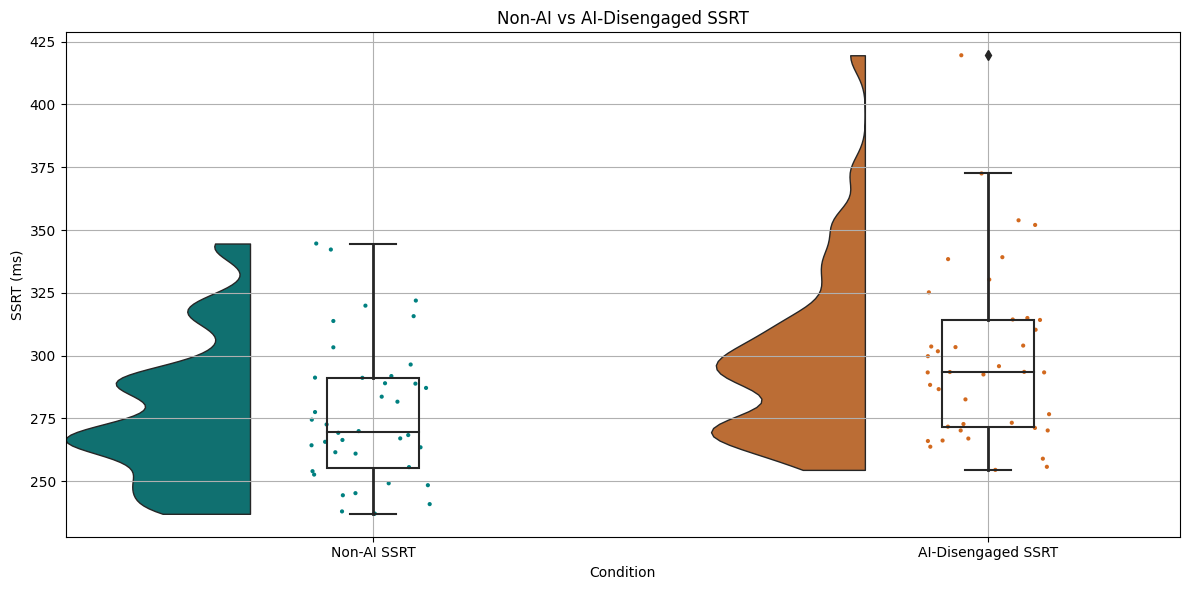

In [791]:
# Raincloud plot for AI vs Non AI SSRT
plt.figure(figsize=(12, 6))

# Create a new axis for the plot
ax = plt.gca()  # Get the current axes

#Create the raincloud plot
raincloud = pt.RainCloud(x='Condition', y='SSRT', data=melted_df_ssrt,
                          palette={"Non-AI SSRT": "teal", "AI-Disengaged SSRT": "chocolate"},
                          width_viol=0.6, ax=ax)

# Add titles and labels
ax.set_title('Non-AI vs AI-Disengaged SSRT')
ax.set_xlabel('Condition')
ax.set_ylabel('SSRT (ms)')
ax.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/non_ai_vs_ai_ssrt_raincloud_plots.png', dpi=300)
plt.show()

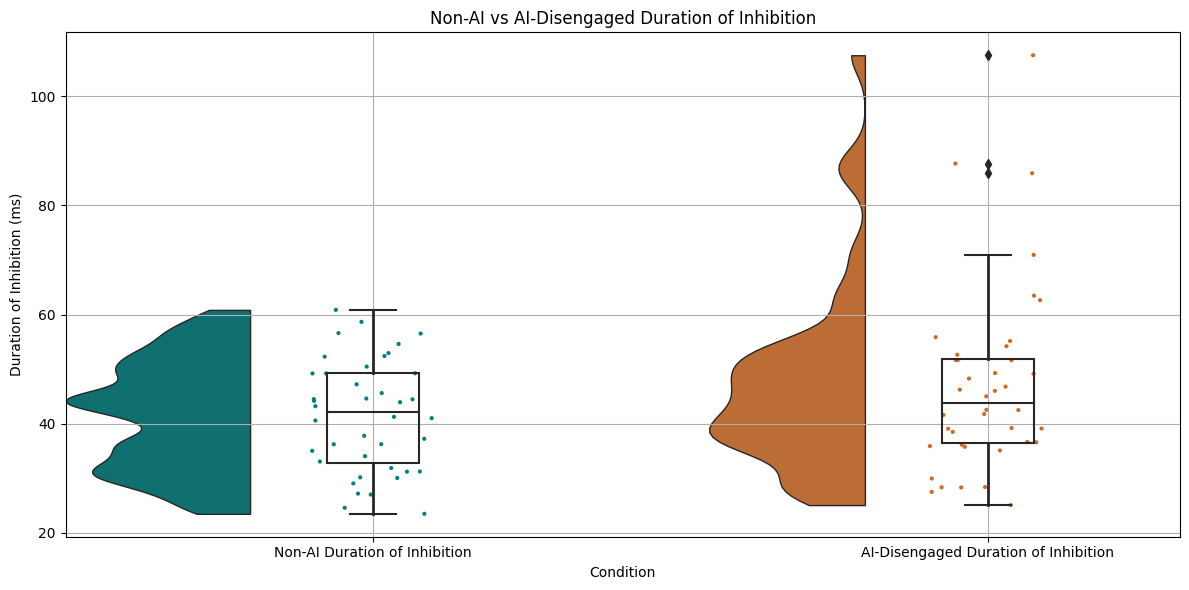

In [792]:
# Step 3: Create the raincloud plot
plt.figure(figsize=(12, 6))
ax = plt.gca()  # Get the current axes

raincloud = pt.RainCloud(
    x='Condition', 
    y='Duration of Inhibition', 
    data=melted_df_duration,
    palette={"Non-AI Duration of Inhibition": "teal", 
             "AI-Disengaged Duration of Inhibition": "chocolate"},
    width_viol=0.6, 
    ax=ax
)

# Add titles and labels
ax.set_title('Non-AI vs AI-Disengaged Duration of Inhibition')
ax.set_xlabel('Condition')
ax.set_ylabel('Duration of Inhibition (ms)')
ax.grid()

# Finalize layout and show the plot
plt.tight_layout()
plt.savefig('figures/non_ai_vs_ai_duration_of_inhibition_raincloud_plots.png', dpi=300) 
plt.show()

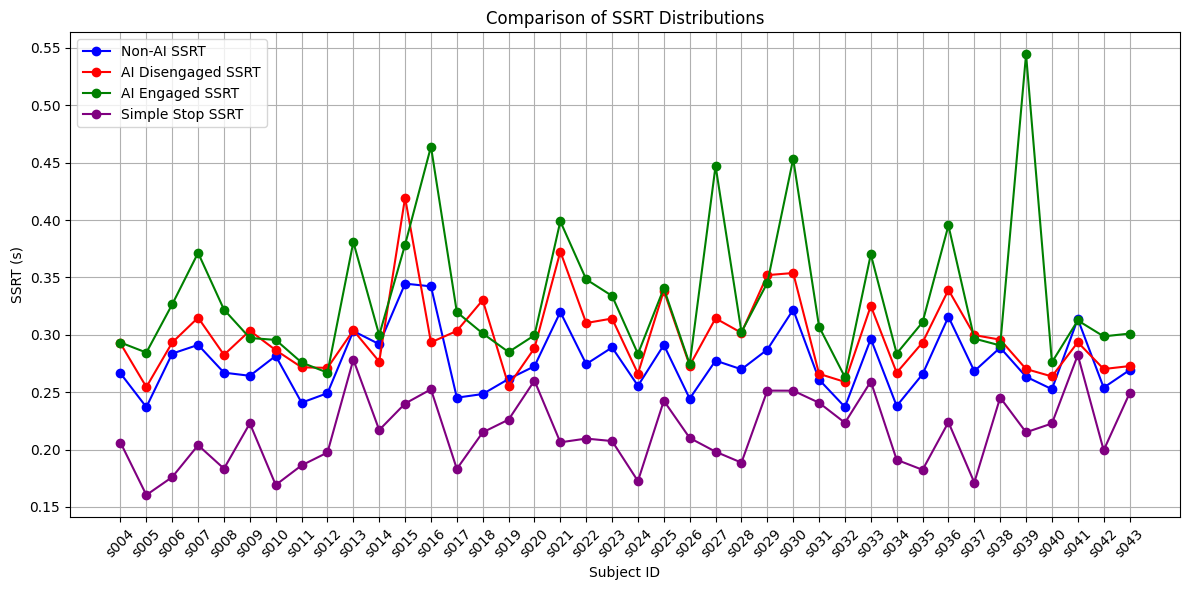

In [793]:
#Create a line plot of SSRT
# Plotting the SSRT distributions together
plt.figure(figsize=(12, 6))

# Plot each condition's SSRT on the same axes
plt.plot(merged_df['subject_id'], merged_df['non_ai_ssrt'], label='Non-AI SSRT', marker='o', color='blue')
plt.plot(merged_df['subject_id'], merged_df['ai_disengaged_ssrt'], label='AI Disengaged SSRT', marker='o', color='red')
plt.plot(merged_df['subject_id'], merged_df['ai_engaged_ssrt'], label='AI Engaged SSRT', marker='o', color='green')
plt.plot(merged_df['subject_id'], merged_df['simple_stop_ssrt'], label='Simple Stop SSRT', marker='o', color='purple')

# Titles and labels
plt.title('Comparison of SSRT Distributions')
plt.xlabel('Subject ID')
plt.ylabel('SSRT (s)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

# Save the figure and show
plt.savefig('figures/ssrt_distributions_comparison.png', dpi=300)
plt.show()

Means of SSRT by Condition:
ai_disengaged_ssrt: 298.88 ms
ai_engaged_ssrt: 331.03 ms
non_ai_ssrt: 276.17 ms
simple_stop_ssrt: 215.55 ms


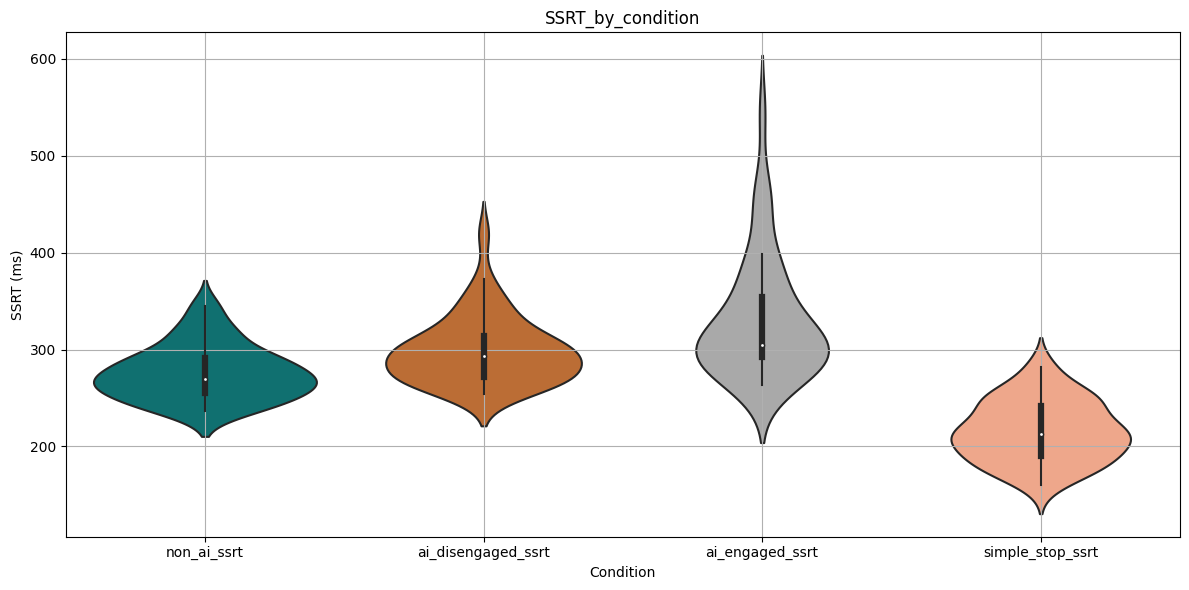

In [794]:
#Create violin plots of all SSRT
# Set up the figure for the violin plots
plt.figure(figsize=(12, 6))

# Combine the data into a long format suitable for Seaborn
melted_df = merged_df.melt(id_vars='subject_id', value_vars=['non_ai_ssrt', 'ai_disengaged_ssrt', 'ai_engaged_ssrt', 'simple_stop_ssrt'],
                            var_name='Condition', value_name='SSRT')
melted_df['SSRT'] *= 1000

# Calculate and print the means for each condition
means = melted_df.groupby('Condition')['SSRT'].mean()
print("Means of SSRT by Condition:")
for condition, mean_value in means.items():
    print(f"{condition}: {mean_value:.2f} ms")

# Create violin plots
sns.violinplot(x='Condition', y='SSRT', data=melted_df, palette={"non_ai_ssrt": "teal", "ai_disengaged_ssrt": "chocolate", 'ai_engaged_ssrt': "darkgray", 'simple_stop_ssrt': "lightsalmon"})

# Add titles and labels
plt.title('SSRT_by_condition')
plt.xlabel('Condition')
plt.ylabel('SSRT (ms)')
plt.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/all_ssrt_violin_plots.png', dpi=300)
plt.show()

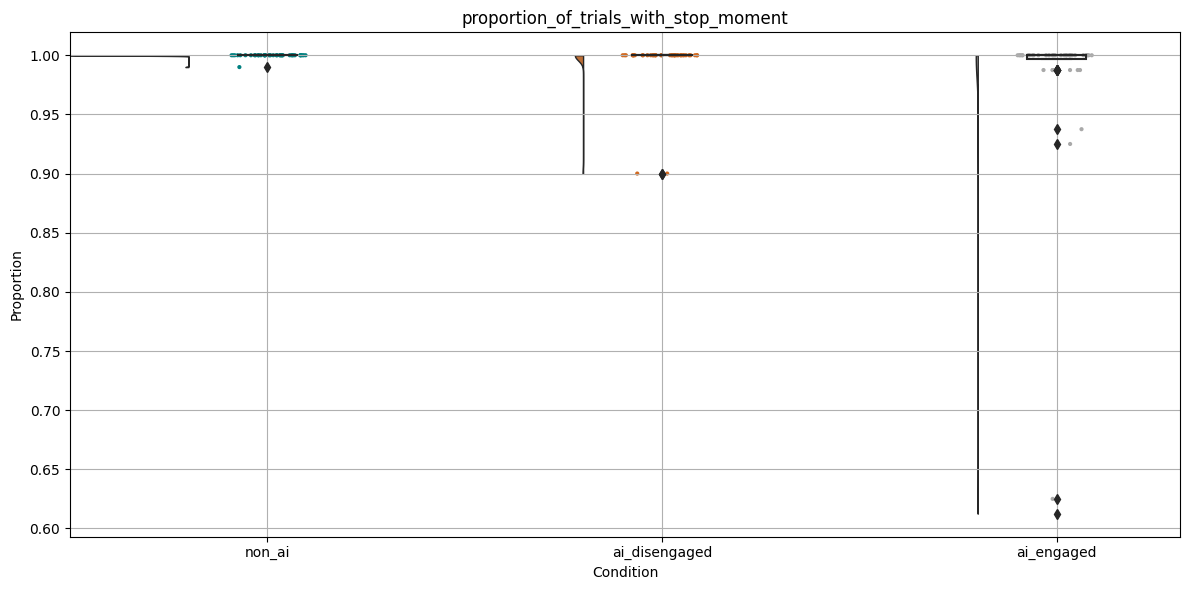

Raincloud plot saved as proportion_of_trials_with_stop_moment


In [795]:
#proportion_of_trials_with_stop_moment = proportion_of_trials_with_stop_moment[proportion_of_trials_with_stop_moment['proportion_ai_ai_trials_with_stop_moment'] >= 0.90]
create_raincloud_plot(proportion_of_trials_with_stop_moment, 'Proportion')

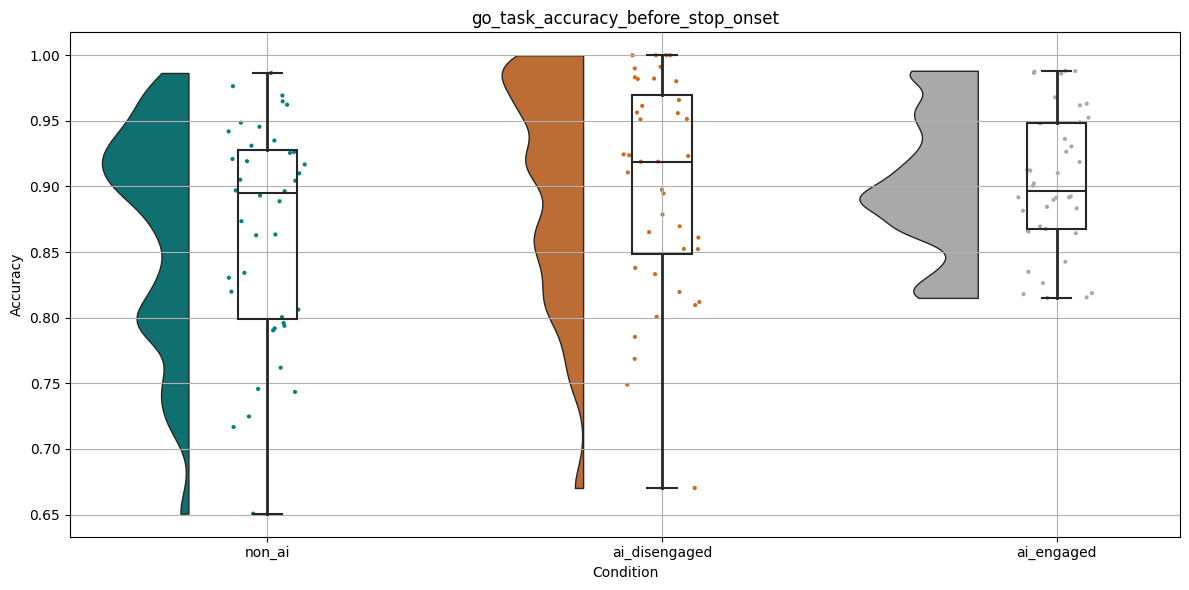

Raincloud plot saved as go_task_accuracy_before_stop_onset


In [796]:
create_raincloud_plot(go_task_accuracy_before_stop_onset, 'Accuracy')

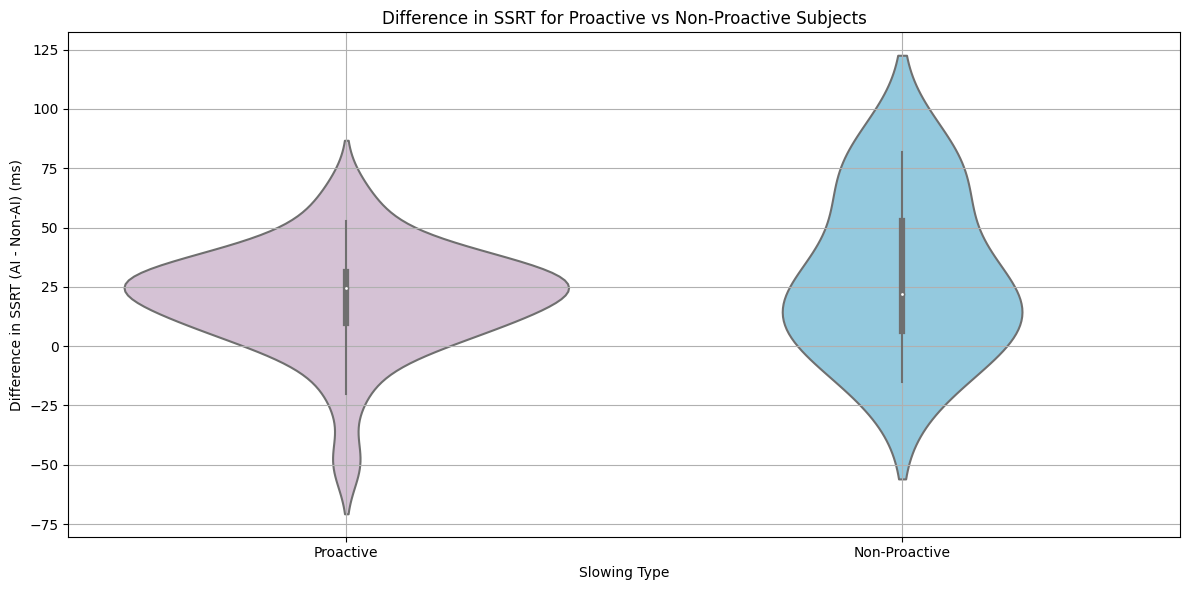

In [797]:
#Create violin plots of AI - Non AI SSRT in proactive vs non-proactive slowing subjects

# Identify non-proactive slowing subjects
non_proactive_slowing_mask = (go_task_accuracy_before_stop_onset['non_ai'] > 
                               go_task_accuracy_before_stop_onset['ai_disengaged'])

# Extract subject IDs of subjects who showed non-proactive slowing
non_proactive_slowing_subs = go_task_accuracy_before_stop_onset['subject_id'][non_proactive_slowing_mask].tolist()

# Extract SSRT values for AI and Non-AI conditions
ssrt_non_ai = shared_control_ssrt['non_ai_ssrt']
ssrt_ai = shared_control_ssrt['ai_ssrt']

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'subject_id': shared_control_ssrt['subject_id'],
    'ssrt_non_ai': ssrt_non_ai,
    'ssrt_ai': ssrt_ai
})

# Remove the row(s) where subject_id is 'mean'
plot_data = plot_data[plot_data['subject_id'] != 'mean']

# Calculate the difference between AI SSRT and Non-AI SSRT
plot_data['difference'] = plot_data['ssrt_ai'] - plot_data['ssrt_non_ai']

# Classify subjects based on proactive slowing
plot_data['slowing_type'] = ['Non-Proactive' if subject in non_proactive_slowing_subs else 'Proactive' 
                              for subject in plot_data['subject_id']]

plot_data['difference_ms'] = plot_data['difference'] * 1000

violin_data = plot_data[['difference_ms', 'slowing_type']]
plt.figure(figsize=(12, 6))
sns.violinplot(x='slowing_type', y='difference_ms', data=violin_data, palette={'Non-Proactive': 'skyblue', 'Proactive': 'thistle'})
plt.title('Difference in SSRT for Proactive vs Non-Proactive Subjects')
plt.xlabel('Slowing Type')
plt.ylabel('Difference in SSRT (AI - Non-AI) (ms)')
plt.grid()
plt.tight_layout()
plt.savefig('figures/ssrt_difference_proactive_vs_non_proactive.png', dpi=300) 
plt.show()

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_1461/3042784272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_proactive_slowing_data.rename(columns={'ssrt_ai': 'ssrt_ai_disengaged'}, inplace=True)


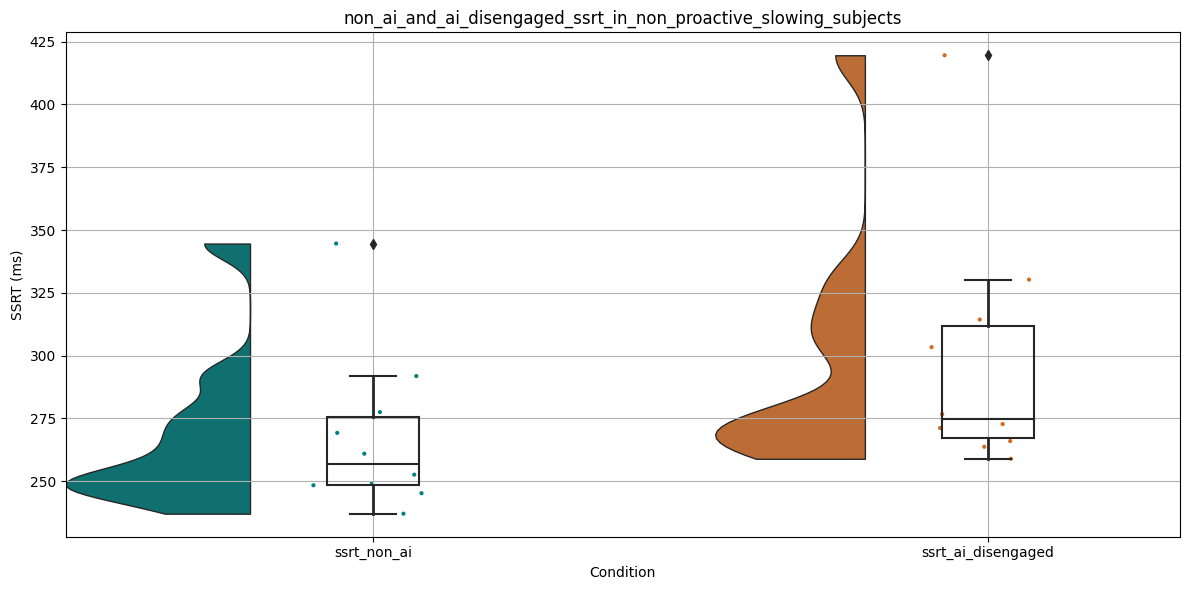

In [798]:
plt.figure(figsize=(12, 6))
non_proactive_slowing_data = plot_data[plot_data['slowing_type'] == 'Non-Proactive']
# Combine the data into a long format suitable for Seaborn
non_proactive_slowing_data.rename(columns={'ssrt_ai': 'ssrt_ai_disengaged'}, inplace=True)
melted_df = non_proactive_slowing_data.melt(id_vars='subject_id', value_vars=['ssrt_non_ai', 'ssrt_ai_disengaged'],
                            var_name='Condition', value_name='SSRT')
melted_df['SSRT'] *= 1000  # Convert to milliseconds

# Create a new axis for the plot
ax = plt.gca()  # Get the current axes

# Create the raincloud plot
raincloud = pt.RainCloud(x='Condition', y='SSRT', data=melted_df,
                          palette={"ssrt_non_ai": "teal", "ssrt_ai_disengaged": "chocolate"},
                          width_viol=0.6, ax=ax)

# Add titles and labels
ax.set_title('non_ai_and_ai_disengaged_ssrt_in_non_proactive_slowing_subjects')
ax.set_xlabel('Condition')
ax.set_ylabel('SSRT (ms)')
ax.grid()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/non_ai_and_ai_disengaged_ssrt_in_non_proactive_slowing_subjects.png', dpi=300)
plt.show()

## Exploratory T-tests and Confidence Intervals

In [799]:
# Calculate CIs for SSRT
calc_ci_for_individual_metrics(melted_df_ssrt)

Means DataFrame:
            Condition        Mean       SEM    CI_lower    CI_upper
0  AI-Disengaged SSRT  298.884440  5.497932  287.941081  309.827800
1         Non-AI SSRT  276.169311  4.407977  267.395452  284.943171


In [800]:
# T test for AI vs Non AI Duration of inhibition
t_stat, p_value = stats.ttest_rel(duration_of_inhibition['ai_duration_of_inhibition'], duration_of_inhibition['non_ai_duration_of_inhibition'])
# Print the t-statistic and p-value
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")

cohens_d1 = cohens_d_paired(duration_of_inhibition['ai_duration_of_inhibition'], duration_of_inhibition['non_ai_duration_of_inhibition'])
mean_diff1, ci1 = calculate_ci_for_difference(duration_of_inhibition['ai_duration_of_inhibition'], duration_of_inhibition['non_ai_duration_of_inhibition'])
print("\nAI-Disengaged vs Non AI Duration of inhibition")
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")
calc_ci_for_individual_metrics(melted_df_duration)

T-statistic: 2.692, P-value: 0.0104

AI-Disengaged vs Non AI Duration of inhibition
Cohen's d: 0.602
Mean difference = 0.006 ms
95% CI: [0.001, 0.010] ms
Means DataFrame:
                              Condition       Mean       SEM   CI_lower  \
0  AI-Disengaged Duration of Inhibition  47.237714  2.714099  41.835435   
1         Non-AI Duration of Inhibition  41.473964  1.603309  38.282657   

    CI_upper  
0  52.639992  
1  44.665270  


In [801]:
melted_df_simple_stop_ssrt = merged_df.melt(id_vars='subject_id', value_vars=['non_ai_ssrt', 'simple_stop_ssrt'],
                            var_name='Condition', value_name='SSRT')
melted_df_simple_stop_ssrt['SSRT']*=1000

calc_ci_for_individual_metrics(melted_df_simple_stop_ssrt)

Means DataFrame:
          Condition        Mean       SEM    CI_lower    CI_upper
0       non_ai_ssrt  276.169311  4.407977  267.395452  284.943171
1  simple_stop_ssrt  215.554210  4.925375  205.750496  225.357924


In [802]:
mean_non_ai = go_task_accuracy_before_stop_onset['non_ai'].mean()
mean_ai_disengaged = go_task_accuracy_before_stop_onset['ai_disengaged'].mean()

print(f"Mean Non-AI Accuracy: {mean_non_ai:.2f}")
print(f"Mean AI Disengaged Accuracy: {mean_ai_disengaged:.2f}")

# T test for AI vs Non AI Go task accuracy before stop onset
t_stat, p_value = stats.ttest_rel(go_task_accuracy_before_stop_onset['ai_disengaged'], go_task_accuracy_before_stop_onset['non_ai'])

# Print the t-statistic and p-value
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3f}")

cohens_d1 = cohens_d_paired(go_task_accuracy_before_stop_onset['ai_disengaged'], go_task_accuracy_before_stop_onset['non_ai'])
mean_diff1, ci1 = calculate_ci_for_difference(go_task_accuracy_before_stop_onset['ai_disengaged'], go_task_accuracy_before_stop_onset['non_ai'])
print(f"Cohen's d: {cohens_d1:.2f}")
print(f"Mean difference = {mean_diff1:.2f} ms")
print(f"95% CI: [{ci1[0]:.2f}, {ci1[1]:.2f}] ms")

melted_df_go_task_accuracy = go_task_accuracy_before_stop_onset.melt(id_vars='subject_id', value_vars=['non_ai', 'ai_disengaged'],
                            var_name='Condition', value_name='Go Task Accuracy Before Stop Onset')

calc_ci_for_individual_metrics(melted_df_go_task_accuracy)

Mean Non-AI Accuracy: 0.87
Mean AI Disengaged Accuracy: 0.90
T-statistic: 2.81, P-value: 0.008
Cohen's d: 0.63
Mean difference = 0.03 ms
95% CI: [0.01, 0.06] ms
Means DataFrame:
       Condition      Mean       SEM  CI_lower  CI_upper
0  ai_disengaged  0.900721  0.012925  0.874995  0.926447
1         non_ai  0.866798  0.013170  0.840585  0.893011


In [803]:
# T-test for difference in Non AI and AI SSRT in subjects who didn't show proactive slowing
non_proactive_slowing_data['ssrt_ai_disengaged']*=1000
non_proactive_slowing_data['ssrt_non_ai']*=1000
t_stat, p_value = stats.ttest_rel(non_proactive_slowing_data['ssrt_ai_disengaged'], non_proactive_slowing_data['ssrt_non_ai'])
print(len(non_proactive_slowing_data))
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")

cohens_d1 = cohens_d_paired(non_proactive_slowing_data['ssrt_ai_disengaged'], non_proactive_slowing_data['ssrt_non_ai'])
mean_diff1, ci1 = calculate_ci_for_difference(non_proactive_slowing_data['ssrt_ai_disengaged'], non_proactive_slowing_data['ssrt_non_ai'])
print("\nDifference in Non AI and AI SSRT in subjects who didn't show proactive slowing")
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")

melted_df_non_proactive_slowing = non_proactive_slowing_data.melt(id_vars='subject_id', value_vars=['ssrt_non_ai', 'ssrt_ai_disengaged'],
                            var_name='Condition', value_name='SSRT ')
calc_ci_for_individual_metrics(melted_df_non_proactive_slowing)



10
T-statistic: 2.936, P-value: 0.0166

Difference in Non AI and AI SSRT in subjects who didn't show proactive slowing
Cohen's d: 1.313
Mean difference = 30.018 ms
95% CI: [6.893, 53.142] ms
Means DataFrame:
            Condition        Mean        SEM    CI_lower    CI_upper
0  ssrt_ai_disengaged  297.705859  15.510576  265.241850  330.169868
1         ssrt_non_ai  267.688122  10.017141  246.722004  288.654239


/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_1461/2660384337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_proactive_slowing_data['ssrt_ai_disengaged']*=1000
/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_1461/2660384337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_proactive_slowing_data['ssrt_non_ai']*=1000


In [804]:
non_proactive_differences = plot_data[plot_data['slowing_type'] == 'Non-Proactive']['difference_ms'].dropna()
proactive_differences = plot_data[plot_data['slowing_type'] == 'Proactive']['difference_ms'].dropna()

calc_stats_ind(non_proactive_differences, proactive_differences)
# Print the means
# Calculate the mean difference for each group
mean_non_proactive = plot_data[plot_data['slowing_type'] == 'Non-Proactive']['difference_ms'].mean()
mean_proactive = plot_data[plot_data['slowing_type'] == 'Proactive']['difference_ms'].mean()

ci_non_proactive = stats.t.interval(.95, len(non_proactive_differences)-1, loc=mean_non_proactive, scale=stats.sem(non_proactive_differences))
print(f"Mean difference (Non-Proactive): {mean_non_proactive:.3f} ms, 95% CI: [{ci_non_proactive[0]:.2f}, {ci_non_proactive[1]:.2f}] ms")

ci_proactive = stats.t.interval(.95, len(proactive_differences)-1, loc=mean_proactive, scale=stats.sem(proactive_differences))
print(f"Mean difference (Proactive): {mean_proactive:.3f} ms, 95% CI: [{ci_proactive[0]:.2f}, {ci_proactive[1]:.2f}] ms")


T-statistic: 1.08, P-value: 0.2850
Cohen's d: 0.396
Degrees of Freedom: 38
95% CI for mean difference: [-12.448, 31.922]
Mean difference (Non-Proactive): 30.018 ms, 95% CI: [6.89, 53.14] ms
Mean difference (Proactive): 20.281 ms, 95% CI: [12.20, 28.36] ms


## Correlate and plot survey scores

In [805]:
def correlate_and_plot_survey_scores(column_name):
    #Find the correlation between the survey score and the difference between AI Stop SSRT and Non AI SSRT for each subject
    # Merge without duplicates
    avg_df = merged_df.merge(survey_results, on='subject_id', how='left')

    # Compute the difference between ai and non-ai SSRT
    avg_df['difference_ai_disengaged_and_non_ai_ssrt'] = avg_df['ai_disengaged_ssrt'] - avg_df['non_ai_ssrt']

    # Compute the correlation
    correlation, pval = stats.pearsonr(avg_df[column_name], avg_df["difference_ai_disengaged_and_non_ai_ssrt"])
    print(f"Correlation and p-value between SSRT and survey scores: {correlation}, {pval}")

    avg_df.to_csv(f'/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/{column_name}_survey_by_ssrt.csv')

    avg_df['difference_ai_disengaged_and_non_ai_ssrt'] *= 1000 #convert to ms

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(avg_df['difference_ai_disengaged_and_non_ai_ssrt'], avg_df['average_score'], alpha=0.7)
    plt.title(f'Scatter Plot: {column_name} by SSRT')
    plt.xlabel('Difference between AI-Disengaged and Non AI SSRT (ms)')
    plt.ylabel('Survey Scores')
    plt.grid()
    plt.axhline(0, color='red', linestyle='--')  # Optional: Add a line at y = 0 for reference
    plt.axvline(0, color='red', linestyle='--')  # Optional: Add a line at x = 0 for reference
    plt.tight_layout()
    plt.savefig(f'/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/figures/{column_name}_survey_by_ssrt.png', dpi=300)
    plt.show()

Correlation and p-value between SSRT and survey scores: -0.06668117800291123, 0.6826781257173478


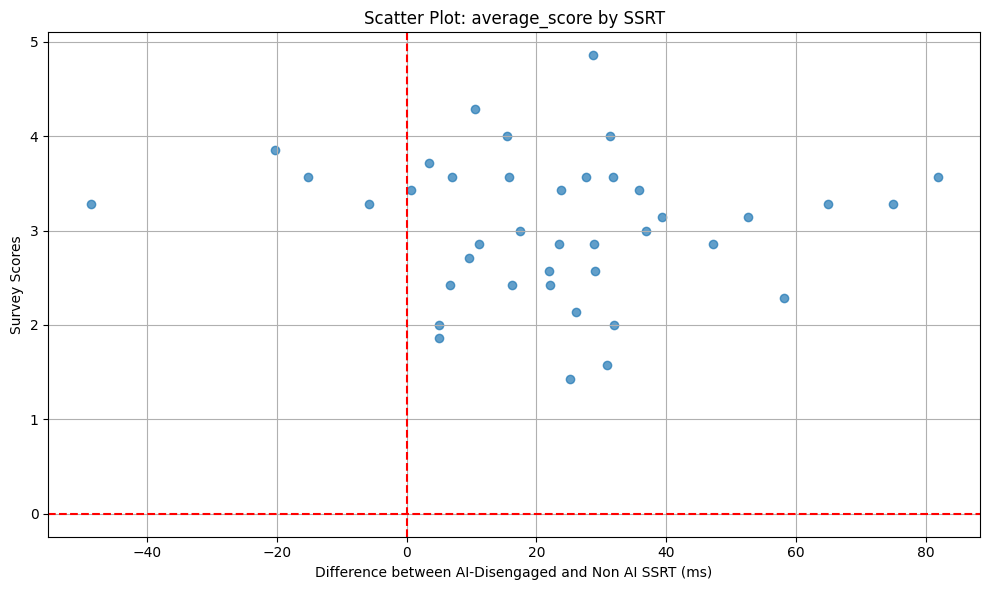

In [806]:
correlate_and_plot_survey_scores('average_score')

Correlation and p-value between SSRT and survey scores: -0.06668117800291123, 0.6826781257173478


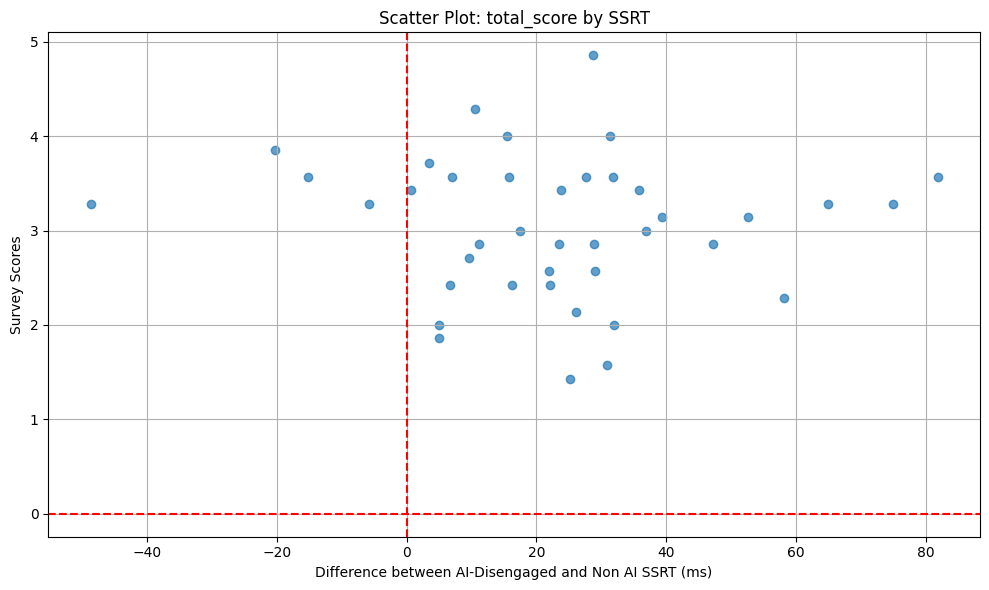

In [807]:
correlate_and_plot_survey_scores('total_score')

Correlation and p-value between SSRT and survey scores: -0.15024221928740658, 0.35478325289283286


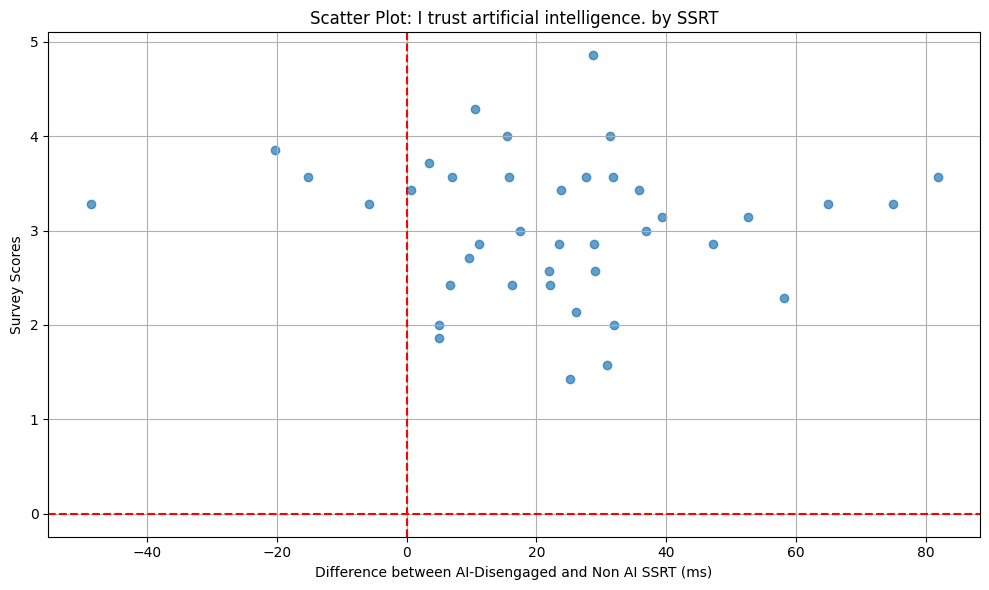

In [808]:
correlate_and_plot_survey_scores('I trust artificial intelligence.')

Correlation and p-value between SSRT and survey scores: 0.07647965005879977, 0.6390341217337844


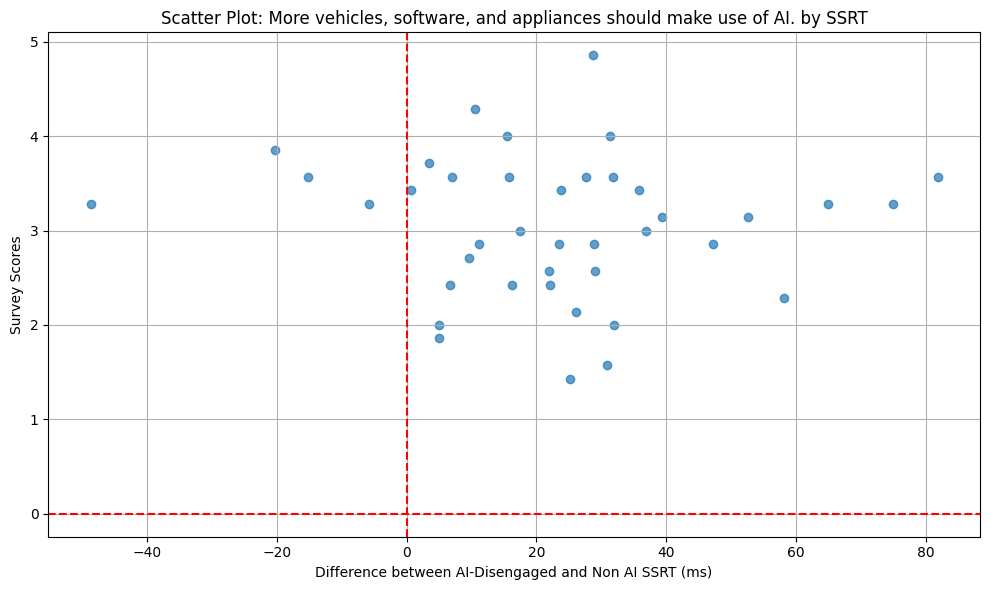

In [809]:
correlate_and_plot_survey_scores('More vehicles, software, and appliances should make use of AI.')

Correlation and p-value between SSRT and survey scores: 0.21790399763843016, 0.17677833178758406


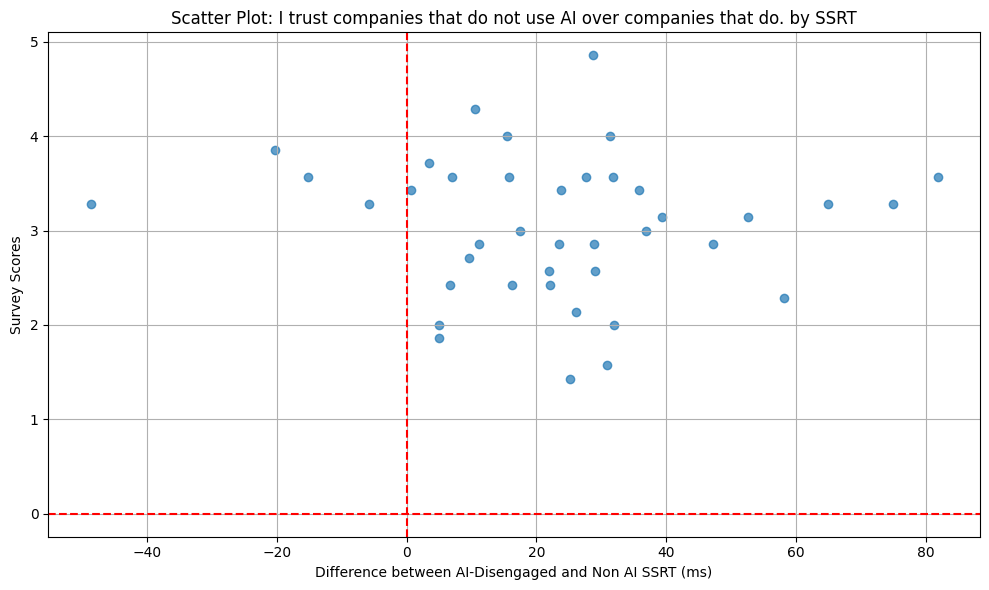

In [810]:
correlate_and_plot_survey_scores('I trust companies that do not use AI over companies that do.')

Correlation and p-value between SSRT and survey scores: -0.06830441221557845, 0.6753723994898313


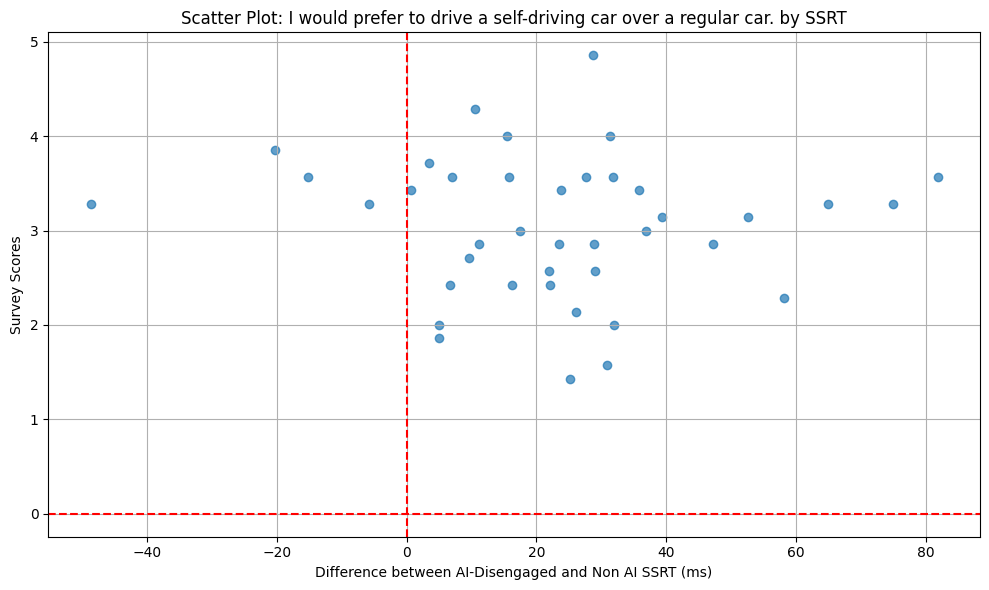

In [811]:
correlate_and_plot_survey_scores('I would prefer to drive a self-driving car over a regular car.')

Correlation and p-value between SSRT and survey scores: -0.0852086738271164, 0.6011338749652766


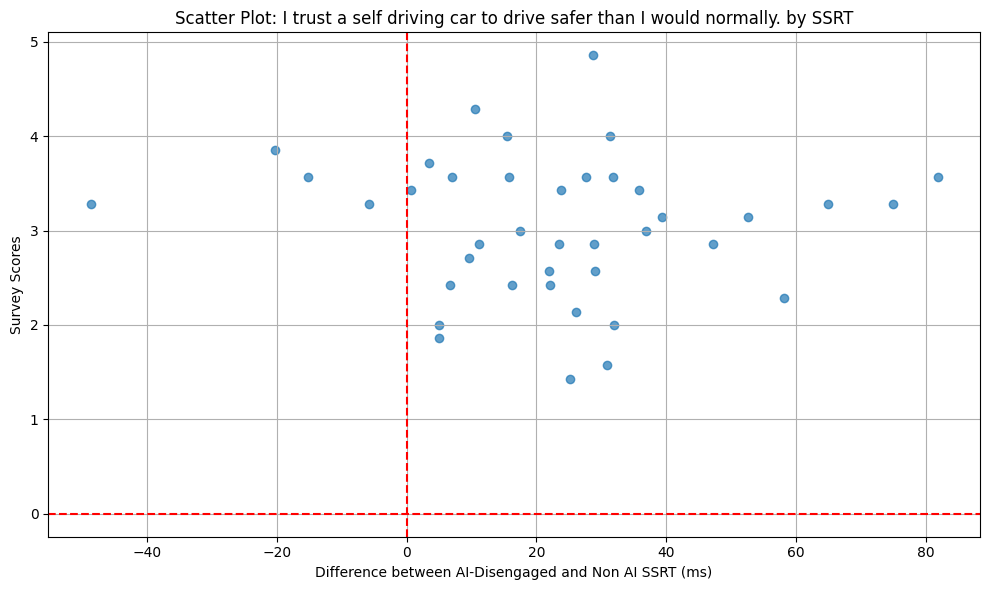

In [812]:
correlate_and_plot_survey_scores('I trust a self driving car to drive safer than I would normally.')

Correlation and p-value between SSRT and survey scores: -0.2215982373544681, 0.16937229822436584


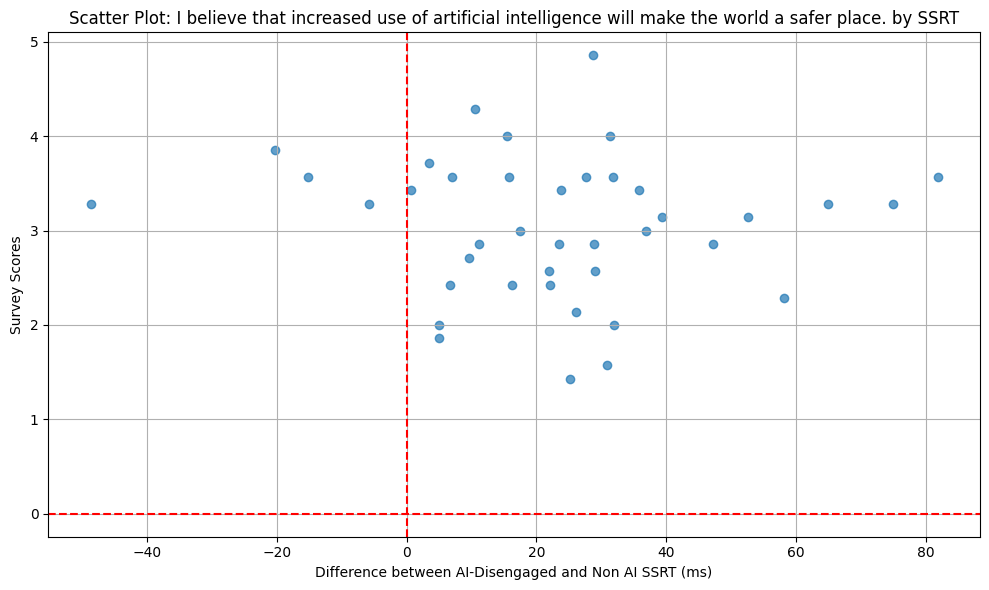

In [813]:
correlate_and_plot_survey_scores('I believe that increased use of artificial intelligence will make the world a safer place.')

Correlation and p-value between SSRT and survey scores: -0.052092212631766346, 0.7495523054953301


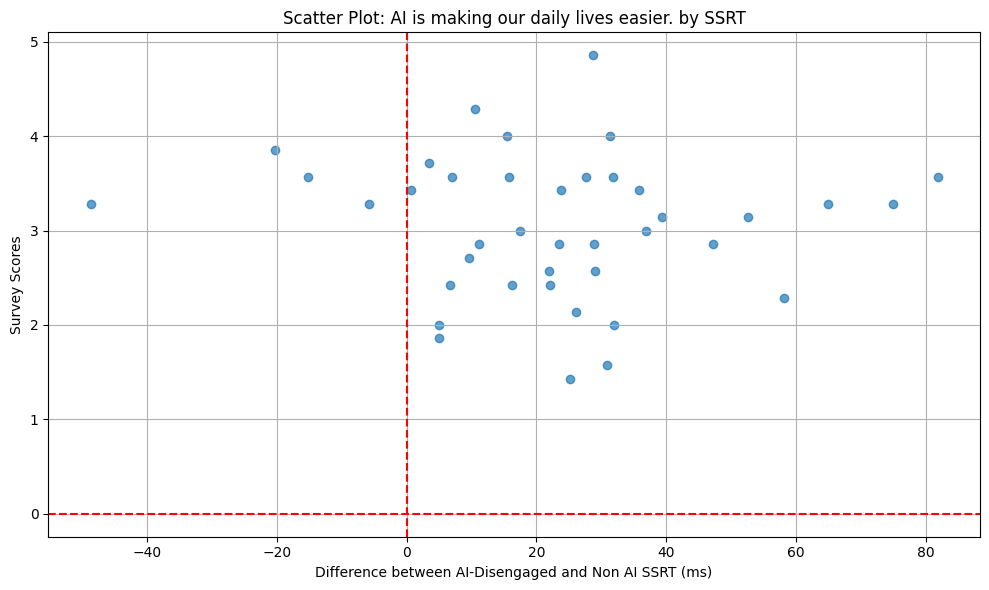

In [814]:
correlate_and_plot_survey_scores('AI is making our daily lives easier.')

In [815]:
def frequency_of_responses_to_survey(column_name):
    """
    Generate a bar chart of responses for a specific survey question.
    
    Parameters:
    - column_name: The text of the survey question.
    - survey_results: A dictionary containing survey responses with subject ID mapping.
    """
    # Handle reverse coding for the specific question
    if column_name == "I trust companies that do not use AI over companies that do.":
        survey_results[column_name] = 6 - survey_results[column_name]

    response_counts = np.bincount(survey_results[column_name].dropna().astype(int), minlength=6)[1:]

    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(1, 6), response_counts, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xticks(np.arange(1, 6)) 
    plt.xlabel("Survey Response")
    plt.ylabel("Frequency")
    plt.title(f'{column_name}')
    plt.grid(axis='y')
    plt.savefig(f'figures/frequency_{column_name}')
    # Show the plot
    plt.tight_layout()
    plt.show()

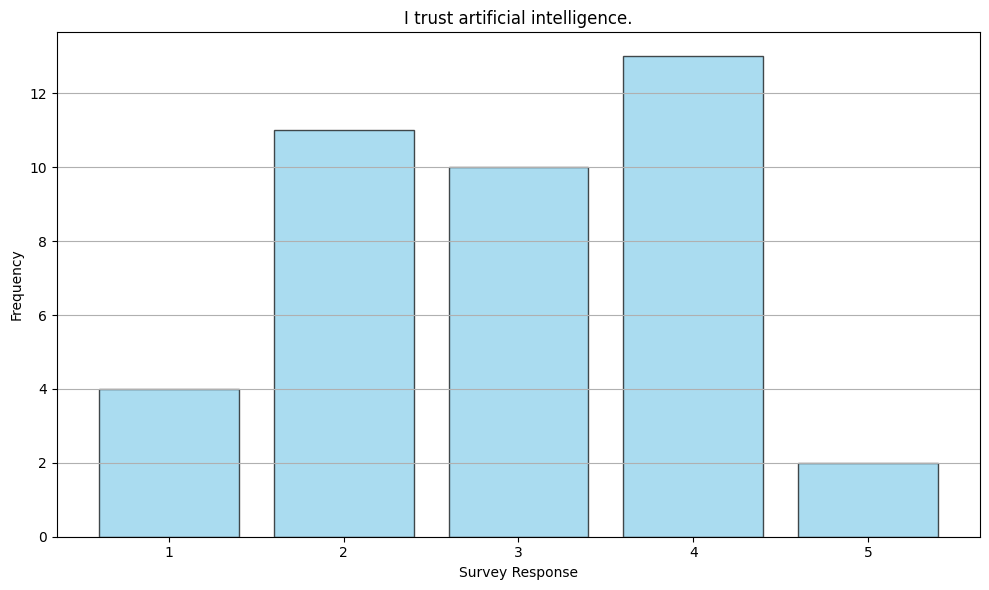

In [816]:
frequency_of_responses_to_survey('I trust artificial intelligence.')

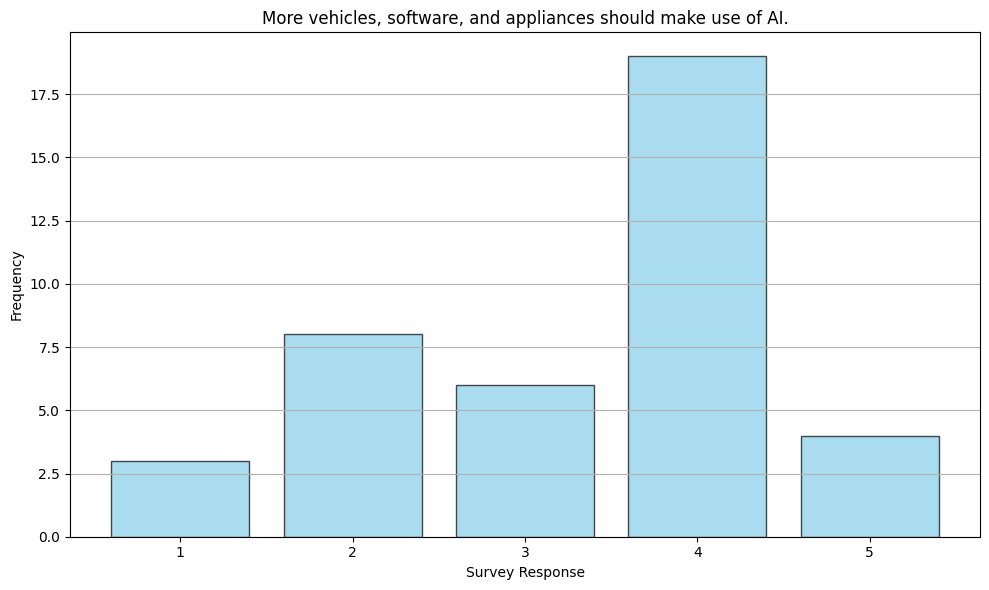

In [817]:
frequency_of_responses_to_survey('More vehicles, software, and appliances should make use of AI.')

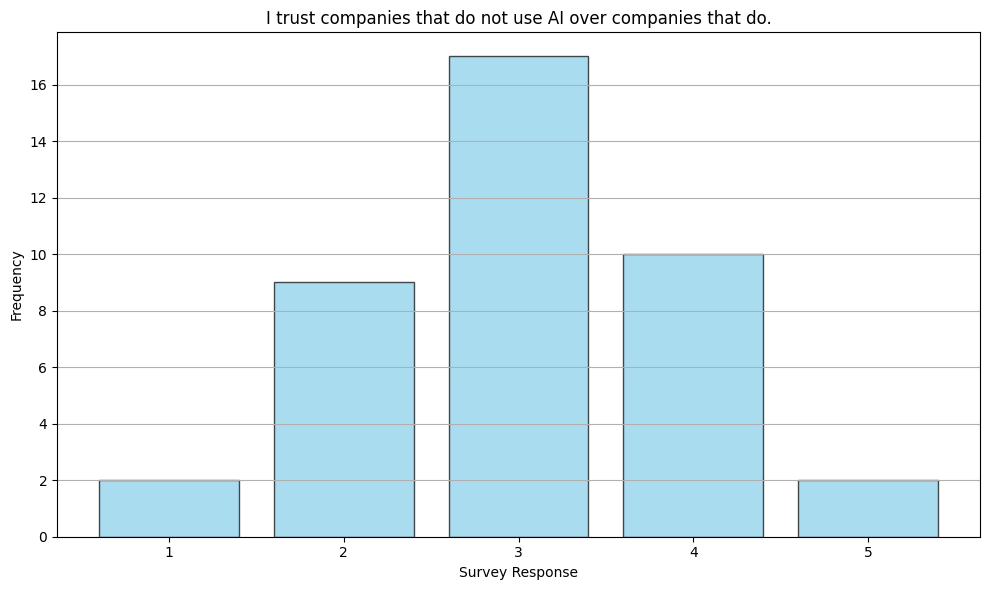

In [818]:
frequency_of_responses_to_survey('I trust companies that do not use AI over companies that do.')

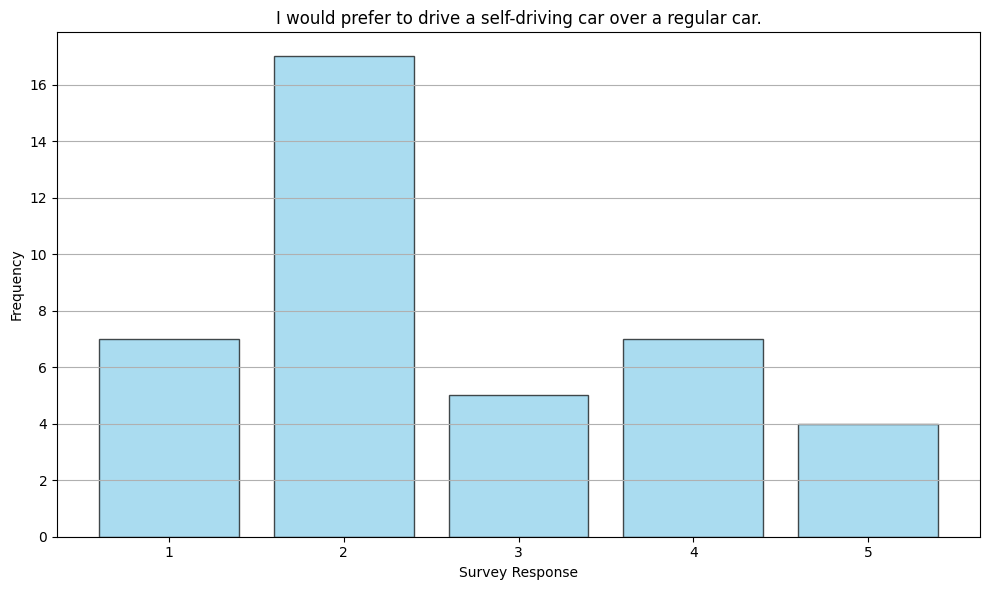

In [819]:
frequency_of_responses_to_survey('I would prefer to drive a self-driving car over a regular car.')

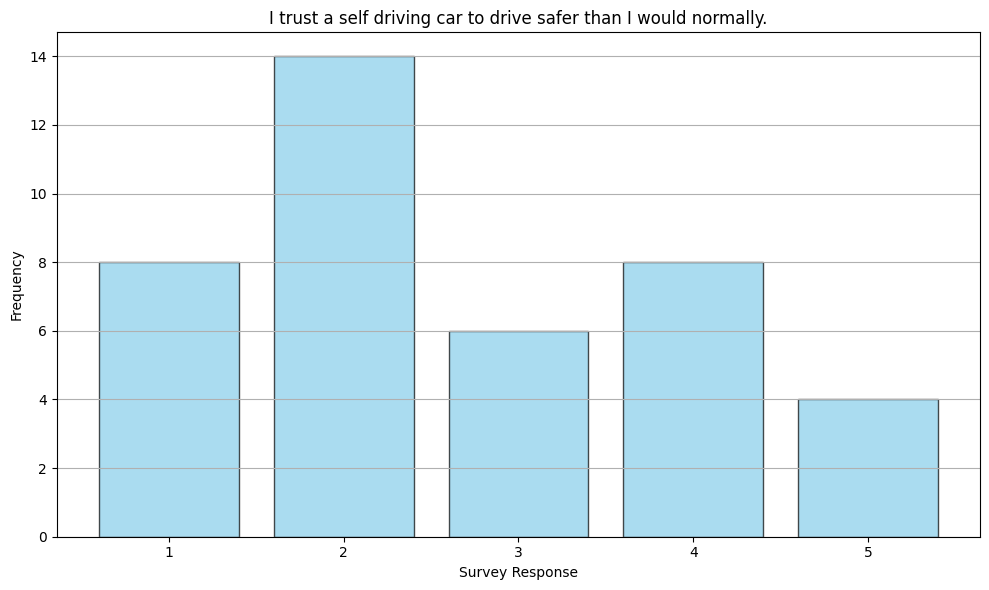

In [820]:
frequency_of_responses_to_survey('I trust a self driving car to drive safer than I would normally.')

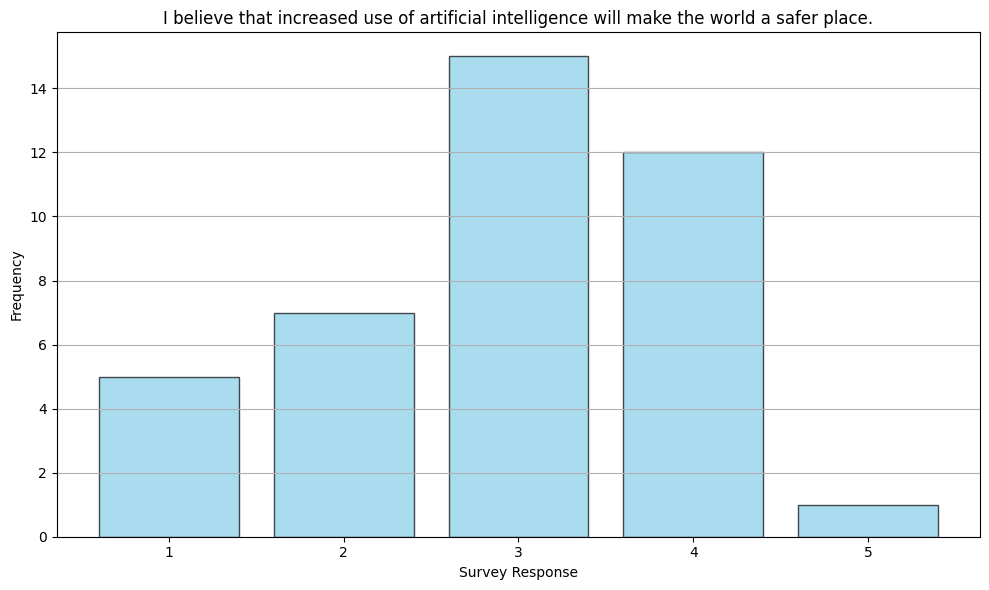

In [821]:
frequency_of_responses_to_survey('I believe that increased use of artificial intelligence will make the world a safer place.')

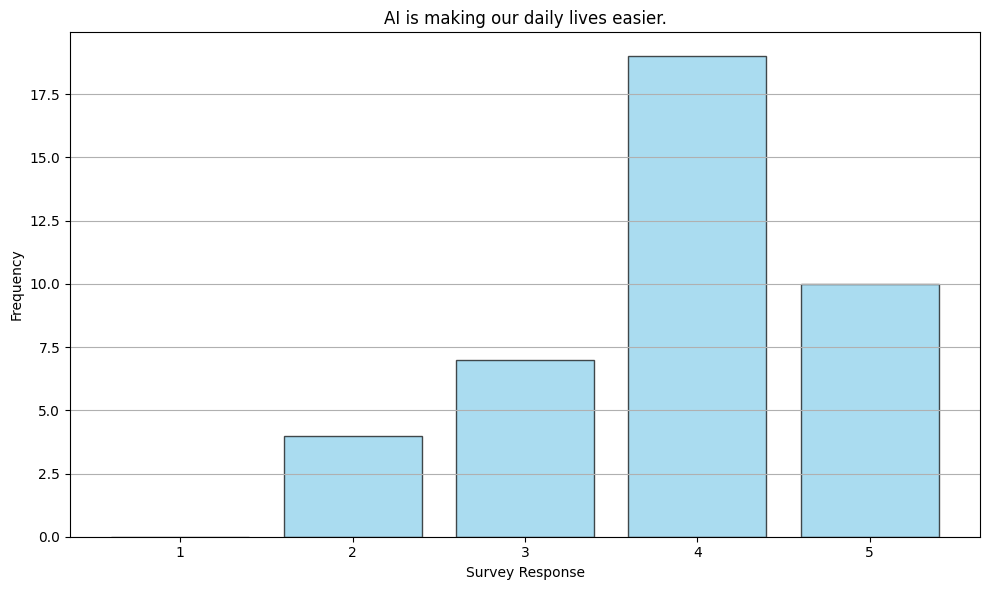

In [822]:
frequency_of_responses_to_survey('AI is making our daily lives easier.')

In [823]:
import subprocess
import re

def clean_requirements():
    # Run pip freeze and capture output
    result = subprocess.run(['pip', 'freeze'], capture_output=True, text=True)

    # Use a regex to filter out lines that include 'file:///' and entries that follow the ' @ ' syntax
    cleaned_output = re.sub(r' @ .*', '', result.stdout)

    # Remove any leading and trailing whitespaces
    cleaned_output = cleaned_output.strip()

    # Remove empty lines (if any)
    cleaned_output = '\n'.join(line for line in cleaned_output.splitlines() if line.strip())

    # Write the cleaned output to a new requirements.txt file
    with open('requirements.txt', 'w') as f:
        f.write(cleaned_output)

    print("Cleaned requirements.txt has been generated.")

# Call the function
clean_requirements()

Cleaned requirements.txt has been generated.
